# Введение в анализ данных
## НИУ ВШЭ, 2019-2020 учебный год

### Домашнее задание №4

Задание выполнил(а): Арина Петросян

### Общая информация

__Дата выдачи:__ 24.05.2020

__Дедлайн:__ 23:59 07.06.2020


### Оценивание и штрафы

Оценка за ДЗ вычисляется по следующей формуле:

$$
min(\text{points}, 19)  \times 10 / 19,
$$

где points — количество баллов за обязательную часть, которое вы набрали. Максимальное число баллов, которое можно получить за обязательную часть — 19, а максимальное число дополнительных баллов, которые пойдут в бонус — 1.

За сдачу задания позже срока на итоговую оценку за задание накладывается штраф в размере 1 балл в день, но получить отрицательную оценку нельзя.

__Внимание!__ Домашнее задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов.

### Формат сдачи

Загрузка файлов с решениями происходит в системе [Anytask](https://anytask.org/).

Инвайт для группы ИАД-4: zG1cIyT

Перед отправкой перезагрузите ноутбук и проверьте, что все ячейки могут быть последовательно выполнены. Ноутбук должен запускаться с использованием python 3.6+

In [2]:
import numpy as np
import matplotlib
from sklearn.datasets import load_breast_cancer, load_boston
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from tqdm import tqdm_notebook as tqdm
from mlxtend.plotting import plot_decision_regions

## Random Forest своими руками (4 балла)

Реализуйте алгоритм случайного леса. В соответствии с построением алгоритма, ваша реализация должна сочетать в себе метод бэггинга и метод случайных подмножеств. Также она должна работать для двух типов задач: как для задачи регрессии, так и для задачи классификации.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn`.*

In [38]:
class RandomForest:
    def __init__(self, n_estimators, max_depth, max_features='sqrt', task_type='regression'):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        max_features - maximum features for each split in DecisionTree from sklearn
        task_type - 'regression' or 'classification'
        """
        self.n = n_estimators
        self.m_d = max_depth
        self.m_f = max_features
        self.task_type = task_type
        
        self.trees = []
        self.f = []
        pass
        
        
    def fit(self, X_train, y_train):
        """
        INPUT:
        X_train - np.array of shape (k, d)
        y_train - np.array of shape (k,)
        """
        sh = X_train.shape
        indicies = np.random.choice(sh[0], size=(self.n, sh[0]), replace=True)
        for i in range(self.n):
            
            X_random = X_train[indicies[i]]
            y_random = y_train[indicies[i]]
            
            if self.task_type == 'regression':
                tree = DecisionTreeRegressor(max_depth = self.m_d, max_features = self.m_f)
            else:
                tree = DecisionTreeClassifier(max_depth = self.m_d, max_features = self.m_f)
            
            tree.fit(X_random, y_random)
            self.trees.append(tree)
        
        
    def predict(self, X_test):
        """
        INPUT:
        X_test - np.array of shape (m, d)
        
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        y_all_pred = np.zeros((len(X_test), self.n))
        
        for i, tree in enumerate(self.trees):
            y_all_pred[:, i] = tree.predict(X_test)
            
        y_pred = np.mean(y_all_pred, axis=1)
            
        if self.task_type == 'regression':
            return y_pred
        else:
            return (y_pred > 0.5).astype('int')

Проверьте вашу реализацию на задаче регрессии. Подберите оптимальные гиперпараметры, чтобы получить MSE < 10.25 **(не меняйте параметры сида)**.

In [39]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [40]:
np.random.seed(19052019)

rf_reg = RandomForest(100, max_depth = 16, max_features= 5, task_type='regression')
rf_reg.fit(X_train, y_train)

print(f'MSE для задачи регрессии: {mean_squared_error(y_test, rf_reg.predict(X_test))}')

MSE для задачи регрессии: 9.37131660022315


Проверьте вашу реализацию на задаче классификации. Подберите оптимальные гиперпараметры, чтобы получить accuracy > 0.83 **(не меняйте параметры сида)**.

In [41]:
breast_cancer = load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [42]:
np.random.seed(19052019)

rf_clf = RandomForest(100, max_depth = 21, max_features=3, task_type='classification')
rf_clf.fit(X_train, y_train)

y_pred_clf = rf_clf.predict(X_test)
print(f'Accuracy для задачи классификации: {accuracy_score(y_test, y_pred_clf)}') 

Accuracy для задачи классификации: 0.9440559440559441


## Градиентный бустинг своими руками (5 + 1* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним основные формулы.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$. Однако чтобы получить дополнительный 1 балл вам нужно реализовать нахождение оптимального $\gamma_N$ на каждом шаге.

В качестве функции потерь возьмите MSE.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

#### **!** Два разных кода для Бустинга: первый с $\gamma=1$, а второй с весами

In [43]:
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self.n = n_estimators
        self.m_d = max_depth
        self.l_r = learning_rate
        self.trees = []
        pass
        
    def fit(self, X_train, y_train):
        """
        INPUT:
        X_train - np.array of shape (k, d)
        y_train - np.array of shape (k,)
        """
        base_model = np.mean(y_train)
        residuals = y_train - base_model
        for _ in range(self.n):
            gamma = 1
            
            b_model = DecisionTreeRegressor(max_depth = self.m_d)
            b_model.fit(X_train, residuals)
            y_pred_b = b_model.predict(X_train)
            
            base_model += self.l_r * gamma * y_pred_b
            residuals = y_train - base_model
            self.trees.append(b_model)
        self.base = np.mean(y_train)
        
    def predict(self, X_test):
        """
        INPUT:
        X_test - np.array of shape (m, d)
        
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        y_all = np.zeros((len(X_test), self.n))
        for i, tree in enumerate(self.trees):
            y_all[:, i] = tree.predict(X_test)
        y_pred = self.base + self.l_r * np.sum(y_all, axis=1)
        
        return y_pred

Проверьте вашу реализацию. Подберите оптимальные гиперпараметры, чтобы получить MSE < 10 как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**.

In [44]:
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [45]:
np.random.seed(19052019)

clf = GradientBoosting(100, 8, learning_rate=0.18)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mse
# YOUR CODE HERE

9.743254967222274

Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- **Да** / Нет

In [46]:
# это может помочь вам для поиска оптимальных gamma

from scipy.optimize import minimize
def fun(gamma:np.array, y_test, base_model, y_pred_b):
    return mean_squared_error(y_test, base_model + gamma * y_pred_b)

In [47]:
# хочу понять, как работает minimize
base_model = np.mean(y_train)
residuals = y_train - base_model
for _ in range(10):
            
            b_model = DecisionTreeRegressor(max_depth = 8, random_state=13)
            b_model.fit(X_train, residuals)
            y_pred_b = b_model.predict(X_train)
            
            g_func = minimize(fun, x0=0.99, args=(y_train, base_model, y_pred_b))
            gamma = g_func.x
            base_model += 0.2 * gamma * y_pred_b
            residuals = y_train - base_model
            print(*gamma, end='; ')

0.9999999929325524; 0.9999999929262237; 0.9999999931009447; 0.999999993685969; 0.9999999941185321; 0.9999999935717367; 0.999999994355084; 0.9999999957874313; 0.9999999972580812; 0.9999999986869893; 

In [48]:
# Непосредственно код

class GradientBoosting_opt:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self.n = n_estimators
        self.m_d = max_depth
        self.l_r = learning_rate
        self.trees = []
        pass
        
    def fit(self, X_train, y_train):
        """
        INPUT:
        X_train - np.array of shape (k, d)
        y_train - np.array of shape (k,)
        """
        base_model = np.mean(y_train)
        residuals = y_train - base_model
        for _ in range(self.n):
            
            b_model = DecisionTreeRegressor(max_depth = self.m_d)
            b_model.fit(X_train, residuals)
            y_pred_b = b_model.predict(X_train)
            
            g_func = minimize(fun, x0=0.99, args=(y_train, base_model, y_pred_b))
            gamma = g_func.x
            base_model += self.l_r * gamma * y_pred_b
            residuals = y_train - base_model
            self.trees.append(b_model)
        self.base = np.mean(y_train)
        
    def predict(self, X_test):
        """
        INPUT:
        X_test - np.array of shape (m, d)
        
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        y_all = np.zeros((len(X_test), self.n))
        for i, tree in enumerate(self.trees):
            y_all[:, i] = tree.predict(X_test)
        y_pred = self.base + self.l_r * np.sum(y_all, axis=1)
        
        return y_pred

In [49]:
np.random.seed(19052019) # random state не меняла)

clf = GradientBoosting_opt(100, 8, learning_rate=0.31)
clf.fit(X_train, y_train)

y_pred_opt = clf.predict(X_test)
mse_opt = mean_squared_error(y_test, y_pred_opt)

In [50]:
print('Для удобства сравнения:')
print(f'MSE для алгоритма с 𝛾=1: {mse}')
print(f'MSE для алгоритма с нахождением оптимального шага: {mse_opt}')

Для удобства сравнения:
MSE для алгоритма с 𝛾=1: 9.743254967222274
MSE для алгоритма с нахождением оптимального шага: 9.711504209085199


## Ансамблевые методы (10 баллов)

Сопровождайте код изображениями и комментариями. Не игнорируйте вопросы, ваши выводы тоже оцениваются. Чем больше информации вы сможете извлечь, аргументированных выводов сформулировать, тем лучше. Не забывайте подписывать графики и будет вам счастье!

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

**0. (0 баллов) ** Загрузите [датасет](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data), в нем вы найдете данные опрошенных женщин из индейского племени Пима. Будем решать задачу бинарной классификации: в колонке Outcome лежит метка наличия или отсутствия диабета - это наша целевая переменная. Есть ли пропущенные значения?

In [4]:
data = pd.read_csv('./diabetes.csv')

In [5]:
print('Есть ли пропуски в датасете?', data.isnull().any().any())

Есть ли пропуски в датасете? False


In [6]:
# Посмотрим, в каих колонках есть нули 
(data == 0).any() 

Pregnancies                  True
Glucose                      True
BloodPressure                True
SkinThickness                True
Insulin                      True
BMI                          True
DiabetesPedigreeFunction    False
Age                         False
Outcome                      True
dtype: bool

Из всех признаков, нули могут быть только в колонках Outcome и Pregnancies, так как в остальных признаках равенство 0 в реальной жизни невозможно, поэтому заменим в них нули на среднее.

In [7]:
for column in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    data[column][data[column] == 0] = None

C:\Users\arina\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


**1. (0.5 балла)** Как вы думаете, является ли наличие нулей в некоторых колонках фактом того, что эти признаки имеют пропущенные значения? Замените нули на среднее значение признака там, где считаете это целесообразным.

In [8]:
data.fillna(np.mean(data, axis=0), inplace=True)

**2. (1 балл)** Визуализируйте распределение признаков по отдельности для больных диабетом и здоровых. Ваши графики должны быть примерно такими:

![Image](https://d.radikal.ru/d03/2005/f8/0ffb9443cbcf.png)

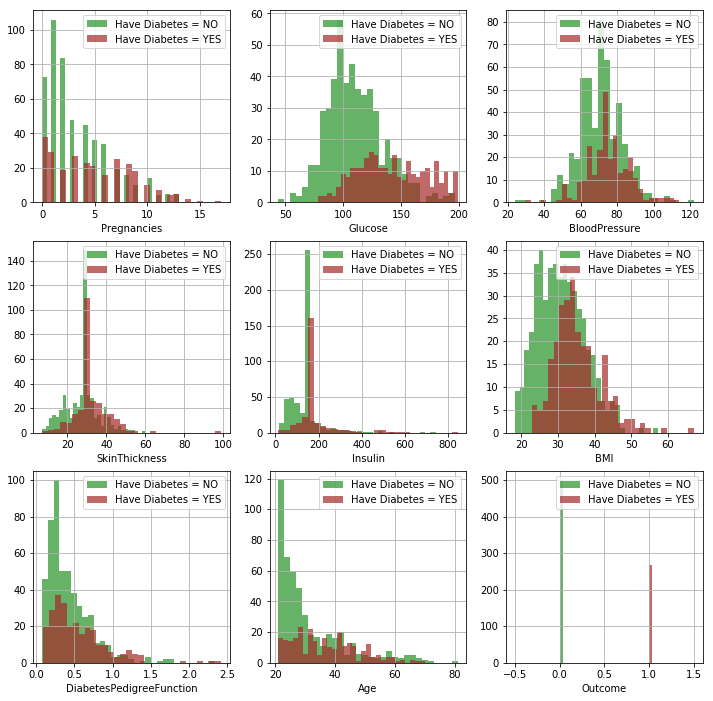

In [9]:
col = np.array(data.columns.tolist()).reshape(3, 3)
fig, ax = plt.subplots(3, 3, figsize=(12, 12))

for i in range(3):
    for j in range(3):
        ax[i, j].hist(data[col[i, j]][data['Outcome'] == 0], bins = 30, color='g', alpha=0.6, label='Have Diabetes = NO')
        ax[i, j].hist(data[col[i, j]][data['Outcome'] == 1], bins = 30, color='brown', alpha=0.7, label='Have Diabetes = YES')
        ax[i, j].set_xlabel(col[i, j])
        ax[i, j].grid()
        ax[i, j].legend(frameon=True)

**3. (2 балла)** Разбейте данные на обучающую и тестовую часть в соотношении 70:30. Обучите `BaggingClassifier` на деревьях (поставьте параметр `'base_estimator' = DecisionTreeClassifier()`) и `RandomForest`. Возьмите количество базовых алгоритмов, равное 10. Посчитайте accuracy, recall и precision. Есть ли какая-то разница между моделями и их результатами? Как вы думаете, почему получились такие результаты?

*Подсказка: создайте отдельную функцию для вывода метрик качества.*

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('Outcome', axis=1), data['Outcome'], test_size=0.3, random_state=13)

In [12]:
def quality(y_test, y_pred):
    print('accuracy', accuracy_score(y_test, y_pred))
    print('recall', recall_score(y_test, y_pred))
    print('precision', precision_score(y_test, y_pred))

In [13]:
# Bagging Classifier
bg_clf = BaggingClassifier(n_estimators=10, base_estimator = DecisionTreeClassifier(), random_state=13)
bg_clf.fit(X_train, y_train)

y_pred_bg = bg_clf.predict(X_test)
quality(y_test, y_pred_bg)

accuracy 0.7272727272727273
recall 0.47126436781609193
precision 0.7068965517241379


In [14]:
# Random Forest
rand_forest = RandomForestClassifier(n_estimators=10, random_state=13)
rand_forest.fit(X_train, y_train)

y_pred_forest = rand_forest.predict(X_test)
quality(y_test, y_pred_forest)

accuracy 0.7748917748917749
recall 0.5862068965517241
precision 0.7611940298507462


В случайном лесе больше доля правильных ответов, что скорее всего, связано с тем, что у него больше элемент случайности (слуайные подмножества наше все), нежели в бэггинге. По этой же причине у него меньше recall

**4. (2 балл)** Для случайного леса проанализируйте значение AUC-ROC на этих же данных в зависимости от изменения параметров:
* `'n_estimators'` (можно перебрать около 10 значений из отрезка от 10 до 1500)
* `'min_samples_leaf'` (сетку значений можете выбрать на ваше усмотрение)

Постройте соответствующие графики зависимости AUC-ROC от этих параметров. Какие выводы вы можете сделать?

In [20]:
np.random.seed
(13)
n_estimators = np.arange(10, 1500, 40)
leaves = np.arange(1, 100, 10)

In [23]:
aucs1 = []
for n in tqdm(n_estimators):
    rand_forest = RandomForestClassifier(n_estimators=n, random_state=13)
    rand_forest.fit(X_train, y_train)
    y_pred_f = rand_forest.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_f[:, 1])
    aucs1.append(auc(fpr, tpr))

In [22]:
aucs2 = []
for m in tqdm(leaves):
    rand_forest = RandomForestClassifier(n_estimators=550, min_samples_leaf=m, random_state=13)
    rand_forest.fit(X_train, y_train)
    y_pred_f = rand_forest.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_f[:, 1])
    aucs2.append(auc(fpr, tpr))

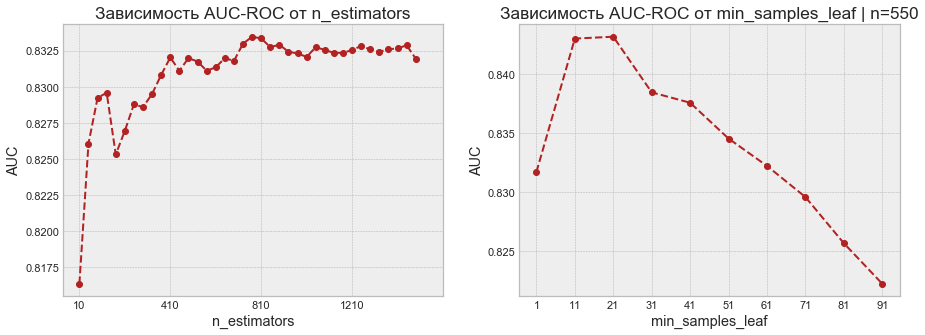

In [24]:
plt.style.use('bmh')
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(aucs1, '--ok', color='firebrick')
ax[0].set_xlabel('n_estimators')
ax[0].set_ylabel('AUC')
ax[0].set_xticks(np.arange(0, 50, 10))
ax[0].set_xticklabels(n_estimators[::10])
ax[0].set_title('Зависимость AUC-ROC от n_estimators')


ax[1].plot(aucs2, '--ok', color='firebrick')
ax[1].set_xlabel('min_samples_leaf')
ax[1].set_ylabel('AUC')  
ax[1].set_xticks(np.arange(10))
ax[1].set_xticklabels(leaves)
ax[1].set_title('Зависимость AUC-ROC от min_samples_leaf | n=550')

plt.show()

Выводы:    
1) n_estimators: как видно из графиков до какого-то момента качество сильно улучшается с ростом количества деревьев (тут до 550) в модели, однако дальнейший рост n практически никак не вияет на качество.    
2) min_samples_leaf: обратная зависимость у качества с минимальным количеством объектов в одном листе, которое работает как критерий Останова. Видим, что оптимально выбирать достаточно маленькое значение для данного параметра (от 1 до 10 в зависимости от установленного n_estimators)

**5. (1 балл)**. Посмотрите, оказались ли какие-то признаки более важными, чем остальные? Воспользуйтесь соответствующим атрибутом случайного леса в библиотеке `sklearn`, чтобы построить `barplot`.

,Importance level
Glucose,0.256898
BMI,0.160353
Age,0.134508
DiabetesPedigreeFunction,0.119604
BloodPressure,0.088336
Pregnancies,0.085550
Insulin,0.078558
SkinThickness,0.076193


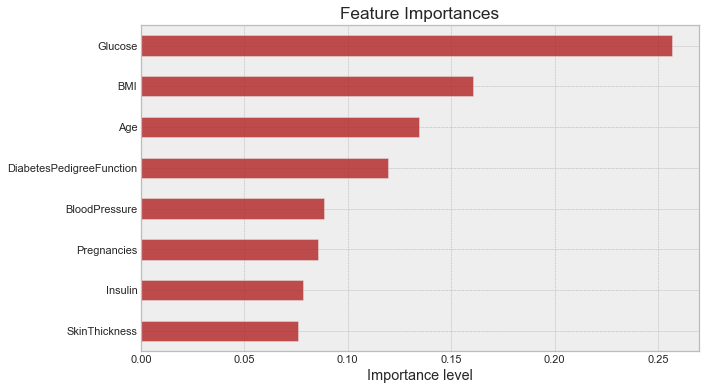

In [27]:
# Важность признаков
df = pd.DataFrame({'Importance level': rand_forest.feature_importances_}, index = data.columns[:-1])
df.sort_values('Importance level').plot.barh(color='firebrick', alpha=0.8, figsize=(10, 6), legend=False)
plt.title('Feature Importances')
plt.xlabel('Importance level')
df.sort_values('Importance level', ascending=False)

**6. (2 балла)** Обучите `HistGradientBoostingClassifier` и `GradientBoostingClassifier` из `sklearn`. Опишите подробно, в чем заключается разница этих моделей. Подберите подходящее количество деревьев и проанализируйте метрики, с которыми мы работали выше.

In [28]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingClassifier

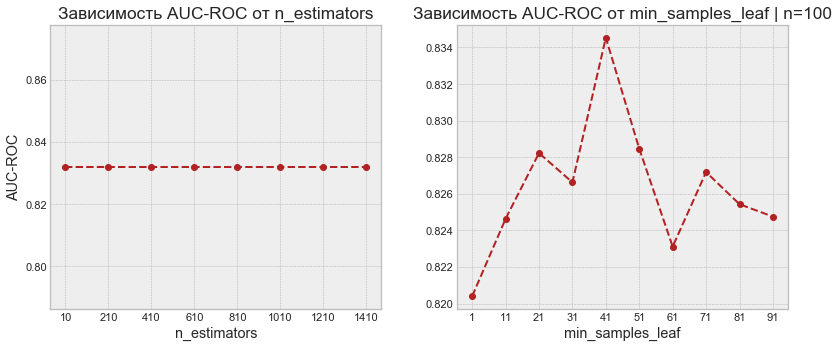

In [29]:
# GradientBoostingClassifier

auc_gb = []
for n in tqdm(n_estimators[::5]):
    gb = GradientBoostingClassifier(n_estimators=n, random_state=13)
    gb.fit(X_train, y_train)
    y_pred_f = rand_forest.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_f[:, 1])
    auc_gb.append(auc(fpr, tpr))
    
auc_leaf_gb = []
for m in tqdm(leaves):
    gb = GradientBoostingClassifier(n_estimators=100, min_samples_leaf=m, random_state=13)
    gb.fit(X_train, y_train)
    y_pred_f = gb.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_f[:, 1])
    auc_leaf_gb.append(auc(fpr, tpr))
    
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(auc_gb, '--ok', color='firebrick')
ax[0].set_xticks(np.arange(8))
ax[0].set_xticklabels(n_estimators[::5])
ax[0].set_title('Зависимость AUC-ROC от n_estimators')
ax[0].set_xlabel('n_estimators')
ax[0].set_ylabel('AUC-ROC')

ax[1].plot(auc_leaf_gb, '--ok', color='firebrick')
ax[1].set_xticks(np.arange(len(leaves)))
ax[1].set_xticklabels(leaves)
ax[1].set_title('Зависимость AUC-ROC от min_samples_leaf | n=100')
ax[1].set_xlabel('min_samples_leaf')

plt.tight_layout()

In [30]:
gb = GradientBoostingClassifier(n_estimators=100, min_samples_leaf=41, random_state=13)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

In [31]:
quality(y_test, y_pred_gb)

accuracy 0.7748917748917749
recall 0.5977011494252874
precision 0.7536231884057971


In [32]:
# HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier(random_state=13)
hgb.fit(X_train, y_train)

quality(y_test, hgb.predict(X_test))

accuracy 0.7532467532467533
recall 0.6091954022988506
precision 0.6973684210526315


Вывод: для HistGradientBoostingClassifier не надо подбирать такие параметры как n_estimators, в отличие от GradientBoostingClassifier. Также, можно заметить, что разница между полнотой и точностью у HistGradientBoostingClassifier значительно меньше, нежели при ипользовании GradientBoostingClassifier

**7. (1.5 балла)** Вспомните, что представляет из себя стэкинг моделей. Возьмите в качестве базовых моделей любой ансамблевый метод из тех, которые были использованы выше, и простой классификатор из уже вами изученных на курсе. В качестве мета-классификатора (модели, обученной на ответах) используйте лог-регресссию. Посчитайте метрики для мета-классификатора. Улучшилось ли качество?

В данном пункте мы можете как написать код для стекинга сами, так и использовать [`StackingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier).

In [33]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import LinearSVC, SVC

In [34]:
gb = GradientBoostingClassifier(n_estimators=100, min_samples_leaf=41, random_state=13)
svm = SVC(random_state=13)
lg = LogisticRegression(random_state=13)

estimators = [
    ('gb', gb),
    ('svm', svm)
]
clf = StackingClassifier(estimators=estimators, final_estimator=lg)

In [35]:
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)

In [36]:
quality(y_test, prediction)

accuracy 0.7705627705627706
recall 0.5402298850574713
precision 0.7833333333333333


In [37]:
for est in [lg, clf, gb]:
    est.fit(X_train, y_train)
    y_pred = est.predict(X_test)
    print('***', est.__class__.__name__, ':', sep='')
    quality(y_test, y_pred)

C:\Users\arina\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


***LogisticRegression:
accuracy 0.7792207792207793
recall 0.5862068965517241
precision 0.7727272727272727
***StackingClassifier:
accuracy 0.7705627705627706
recall 0.5402298850574713
precision 0.7833333333333333
***GradientBoostingClassifier:
accuracy 0.7748917748917749
recall 0.5977011494252874
precision 0.7536231884057971


Как видно, при использовании StackingClassifier доля правильных овтетов осталась такой же, как и при использовании GradientBoostingClassifier и LogisticRegression. Однако сместилось соотношение полноты и точности. 